<a href="https://colab.research.google.com/github/TsabitaNurul/Temu_Kembali_Citra/blob/main/CBIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Definisikan path kaggle json
# Sesuaikan dengan path anda
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/IR"

In [3]:
# Ubah lokasi direktori kerja
# Sesuaikan dengan path anda
%cd /content/drive/My Drive/IR

/content/drive/My Drive/IR


In [4]:
# Cek apakah api sudah terbaca oleh sistem
!ls  

kaggle.json


In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:30<00:00, 42.6MB/s]
100% 2.29G/2.29G [00:30<00:00, 81.4MB/s]


In [6]:
# Cek isi direktori kerja dan memastikan dataset telah berhasil didownload.
!ls

chest-xray-pneumonia.zip  kaggle.json


In [7]:
# Ekstrak file dataset dan hapus file zip dataset agar tidak memakan banyak tempat.
!unzip \*.zip &> /dev/null && rm *.zip

In [8]:
# Cek isi direktori kerja untuk memastikan dataset telah berhasil diekstrak.
!ls

chest_xray  kaggle.json


In [9]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile

TRAIN_DIR = "/content/drive/MyDrive/IR/chest_xray/chest_xray/train/"
VALID_DIR ="/content/drive/MyDrive/IR/chest_xray/chest_xray/val/"
TEST_DIR ="/content/drive/MyDrive/IR/chest_xray/chest_xray/test/"

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 90,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    zoom_range = 0.2
)

test_generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.7
)

In [11]:
train_images = train_generator.flow_from_directory(
    TRAIN_DIR,
    target_size=(64, 64),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)
val_images = test_generator.flow_from_directory(
    VALID_DIR,
    target_size=(64, 64),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset = 'training'
)

test_images = test_generator.flow_from_directory(
    TEST_DIR,
    target_size=(64, 64),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42,
    subset = 'validation'
)

Found 5216 images belonging to 2 classes.
Found 6 images belonging to 2 classes.
Found 436 images belonging to 2 classes.


In [12]:
# TULIS KODE ANDA DISINI
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [13]:
# Print model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 16)        0         
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 16)       0

In [14]:
# Compile model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
history = model.fit(train_images,
                   epochs = 100,
                   validation_data = val_images,
                   callbacks=[tf.keras.callbacks.ReduceLROnPlateau(
                       monitor='val_loss',
                       factor=0.5,
                       patience=40,
                       verbose = 1,
                       mode= 'auto',
                       cooldown = 1
                   )])

Epoch 1/100
163/163 [==============================] - 85s 461ms/step - loss: 0.7955 - accuracy: 0.6252 - val_loss: 1.1771 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/100
163/163 [==============================] - 75s 460ms/step - loss: 0.6373 - accuracy: 0.7218 - val_loss: 1.2454 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/100
163/163 [==============================] - 75s 458ms/step - loss: 0.5684 - accuracy: 0.7487 - val_loss: 1.1231 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/100
163/163 [==============================] - 74s 456ms/step - loss: 0.5289 - accuracy: 0.7799 - val_loss: 0.5224 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 5/100
163/163 [==============================] - 78s 477ms/step - loss: 0.4861 - accuracy: 0.7910 - val_loss: 0.3614 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 6/100
163/163 [==============================] - 76s 463ms/step - loss: 0.4614 - accuracy: 0.8085 - val_loss: 0.4442 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 7/100
163/163 [=

In [16]:
import matplotlib.pyplot as plt
def eval_plot(history):

  plt.figure(figsize=(14, 5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])

  # Loss plot
  plt.subplot(1, 2, 2)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

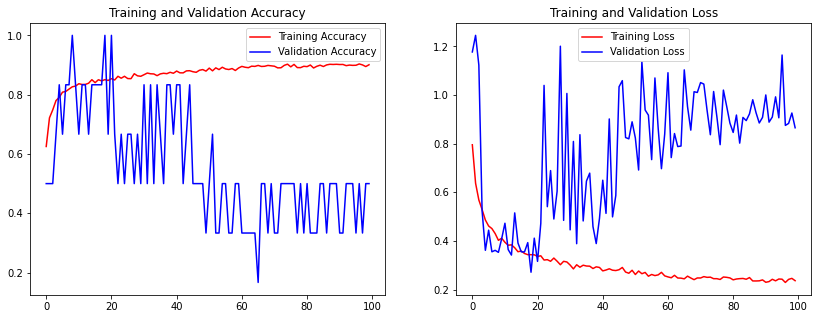

In [17]:
eval_plot(history)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate(model):
  valid_generator = train_generator.flow_from_directory(
      TRAIN_DIR, 
      target_size=(64,64), 
      batch_size=32, 
      class_mode='categorical',
      shuffle = False)

  batch_size = 32
  num_of_test_samples = len(valid_generator.filenames)

  Y_pred = model.predict_generator(valid_generator, num_of_test_samples // batch_size+1)
  y_pred = np.argmax(Y_pred, axis=1)

  print('\nConfusion Matrix\n')
  cm = confusion_matrix(valid_generator.classes, y_pred)
  plt.figure(figsize=(8, 8))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks=[0.5, 1.5], labels=['NORMAL', 'PNEUMONIA'])
  plt.yticks(ticks=[0.5, 1.5], labels=['NORMAL', 'PNEUMONIA'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  print('\n\nClassification Report\n')
  target_names = ['NORMAL', 'PNEUMONIA']
  print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

  tn, fp, fn, tp = cm.ravel()

  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f = 2*((precision*recall)/(precision+recall))

  print("Recall of the model is {:.2f}".format(recall))
  print("Precision of the model is {:.2f}".format(precision))
  print("F-1 Score of the model is {:.2f}".format(f)) 

Found 5216 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  from ipykernel import kernelapp as app



Confusion Matrix



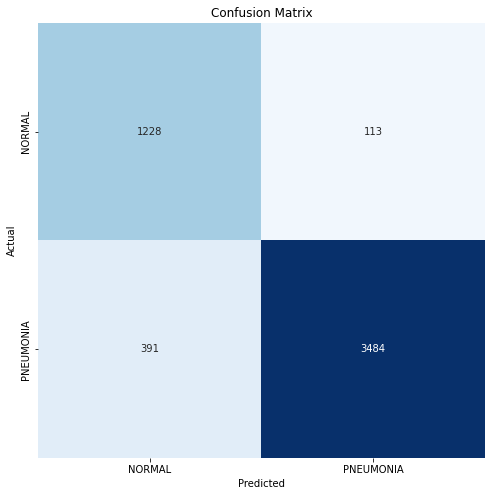



Classification Report

              precision    recall  f1-score   support

      NORMAL       0.76      0.92      0.83      1341
   PNEUMONIA       0.97      0.90      0.93      3875

    accuracy                           0.90      5216
   macro avg       0.86      0.91      0.88      5216
weighted avg       0.91      0.90      0.91      5216

Recall of the model is 0.90
Precision of the model is 0.97
F-1 Score of the model is 0.93


In [19]:
evaluate(model)

In [20]:
# serialize model to JSON
model_json = model.to_json()
with open("IR.json", "w") as json_file: json_file.write(model_json)

In [21]:
# serialize weights to HDF5
model.save("IR.h5")
print("Saved model to disk")

Saved model to disk
